In [2]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from util import *
from node import *
from optim import *
from net import Net

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def loadlabels(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n = struct.unpack(">ll", f.read(2*4))
        assert(_magic == 2049)
        return np.frombuffer(f.read(n), dtype=np.dtype("B"))

def loadimages(filepath):
    with gzip.open(filepath, "rb") as f:
        _magic, n, sx, sy = struct.unpack(">llll", f.read(4*4))
        assert(_magic == 2051)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, sx*sy).astype(np.float32)/255.0
        return ((sx, sy), images)

def load(labelsfp, imagesfp):
    labels = loadlabels(labelsfp)
    size, images = loadimages(imagesfp)
    assert(labels.shape[0] == images.shape[0])
    return (size, labels, images)

In [4]:
ddir = "data/digits/"
print("loading train set")
imgsize, train_labels, train_images = load(ddir + "train-labels-idx1-ubyte.gz", ddir + "train-images-idx3-ubyte.gz")

print("loading test set")
_imgsize, test_labels, test_images = load(ddir + "t10k-labels-idx1-ubyte.gz", ddir + "t10k-images-idx3-ubyte.gz")

assert(imgsize == _imgsize)

loading train set
loading test set


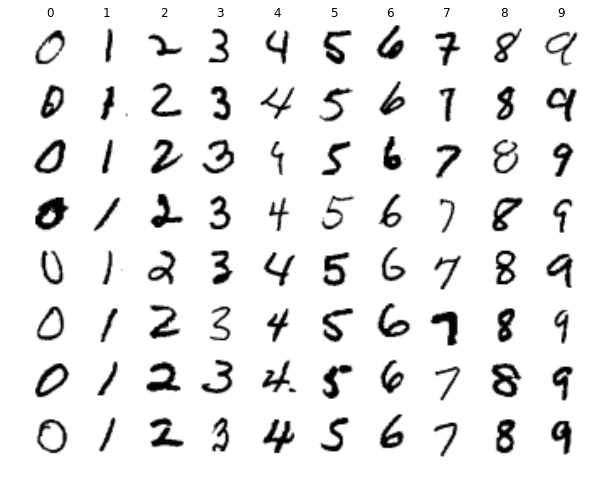

In [5]:
rows = 8
for digit in range(10):
    idxs = np.flatnonzero(np.equal(train_labels, digit))
    idxs = np.random.choice(idxs, rows, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, 10, 10*i + digit + 1)
        plt.imshow(255.0*(1.0 - train_images[idx].reshape(*imgsize)))
        plt.axis('off')
        if i == 0:
            plt.title(digit)

In [58]:
def shuffle_set(labels, images):
    perm = np.random.permutation(labels.shape[0])
    return labels[perm], images[perm]

def plot(train, test):
    plt.subplot(2, 1, 1)
    plt.plot(train[0], train[1], label="Train loss: %.4f" % train[1][-1])
    plt.plot(test[0], test[1], label="Test loss: %.4f" % test[1][-1])
    plt.title("Loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(test[0], test[2])
    plt.yscale("log")
    plt.title("Accuracy: %.2f%%" % (100.0*(1 - test[2][-1])))
    plt.show()

In [74]:
sizes = imgsize[0]*imgsize[1], 50, 10
layers = [n for sx, sy in zip(sizes[:-1], sizes[1:]) for n in [Affine(sx, sy), Bias(sy), Tanh()]][:-1]
links = [(i - 1, i) for i in range(len(layers))] + [(len(layers) - 1, -1)]
net = Net(layers, links)

In [75]:
epoch = 0
pos = 0
smooth_loss = None
train_history, test_history = [[], []], [[], [], []]

In [76]:
batch_size = 100
learn_rate = 1e-1
reg_rate = 5e-3
optim = Adagrad(
    learn_rate=learn_rate, 
    adagrad=net.newgrad(), 
    reg_rate=reg_rate
)

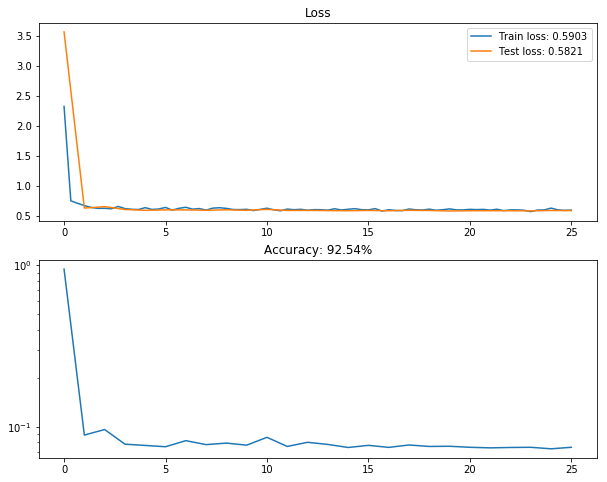

done


In [77]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

while not done:
    if pos == 0:
        _train_labels, _train_images = shuffle_set(train_labels, train_images)
    
    grad = net.newgrad()
    labels = _train_labels[pos:pos+batch_size]
    images = _train_images[pos:pos+batch_size]
    x = images
    y, m = net.feed_mem(x)
    smy = softmax(y)
    dy = ce_softmax_deriv(smy, labels)
    net.backprop(grad, m, dy)
    loss = ce_loss(smy, labels) + reg_loss(net, reg_rate=reg_rate)
    optim.learn(net, grad)
    
    if smooth_loss is None:
        smooth_loss = loss
    smooth_loss = 0.9*smooth_loss + 0.1*loss
    fepoch = epoch + pos/train_labels.shape[0]
    
    if pos == 0:
        x = test_images
        y = net.feed(x)
        smy = softmax(y)
        loss = ce_loss(smy, test_labels) + reg_loss(net, reg_rate=reg_rate)
        accuracy = np.sum(np.equal(np.argmax(y, axis=-1), test_labels))/test_labels.shape[0]
            
        test_history[0].append(fepoch)
        test_history[1].append(loss)
        test_history[2].append(1.0 - accuracy)
        
    if (pos//batch_size) % 200 == 0:
        train_history[0].append(fepoch)
        train_history[1].append(smooth_loss)
        clear_output(wait=True)
        plot(train_history, test_history)
    
    pos += batch_size
    if pos >= train_labels.shape[0]:
        pos = 0
        epoch += 1

print("done")

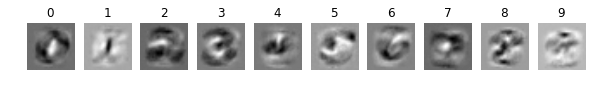

In [78]:
images = np.random.random((10, imgsize[0]*imgsize[1]))*1e-2
labels = np.arange(10)
for i in range(1000):
    grad = net.newgrad()
    y, m = net.feed_mem(images)
    smy = softmax(y)
    dy = ce_softmax_deriv(smy, labels)
    dx = net.backprop(grad, m, dy)
    images -= 1e-2*dx
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(255.0*(1.0 - images[i].reshape(*imgsize)))
    plt.axis('off')
    plt.title(i)
plt.show()